# Mirasol3B - Project report
### Author: YAZID BOUHRIA 2124866

I provide in this project an implementation of the model Mirasol presented in the paper [MIRASOL3B: A MULTIMODAL AUTOREGRESSIVE MODEL FOR TIME-ALIGNED AND CONTEXTUAL MODALITIES](https://arxiv.org/pdf/2311.05698.pdf).

The Mirasol method is an approach for integrating and processing multimodal data, such as audio, video and text, for comprehension and content generation tasks. The implementation focuses on transforming multimodal inputs into latent representations using specific encoders, then combining them via a combination module. Textual context processing is carried out using cross-attention to integrate contextual information. An autoregressive decoder is used to generate predictions based on the combined representations. The aim is to enable the machine to understand and generate content by capturing the nuances of different input modalities.

## Implementation

The implementation that I propose includes several key components for processing and generating content from multimodal data (audio, video and text):
- `RandomData` generates random data for training. 
- `CombinerModel` integrates audio and video representations. 
- `AudioExtractor` and `VideoExtractor` extract features from audio and video inputs respectively. 
- `ContextAutoregressiveModel` and `TemporalAutoregressiveModel` process textual context and generate predictions respectively. 
- `MirasolModel` gather entire process from feature extraction to text generation.

I've deliberately ignored the aspect of segmenting video and audio inputs into timechunks to get my model working on small inputs first.

I thought I'd have time to integrate them later, but that didn't happen because of the difficulties I had implementing this project.

Concerning the dataset, I decided to go on a random generated dataset in order to focus on the neural network building. After that, I tried to implement a Dataset based on samples from the _MSRVTT-QA_ dataset, as suggested in the paper, but my training had some issues with it (mostly because of missing input data segmentation...).

I propose to dive-in the implementation and to explain how components are working

### Datasets
#### RandomDataset
The RandomData class in PyTorch creates a dataset for generating random multimodal data, including audio, video, and textual context, along with random target labels for each instance. It's designed to simulate real-world data for training and testing multimodal machine learning models, providing a customizable number of samples (n). Each sample comprises random tensors representing audio features, video frames, contextual information, and target labels, facilitating the development and testing of models without requiring actual data.

#### CustomVideoDataset
This provide a dataset from the _MSRVTT_ dataset by loading video and audio data. This class extracts and processes video and audio features, including normalizing video inputs and converting audio to a specified sample size. I also converted associated textual information (questions and answers from annotations) into a usable format for the model, such as ASCII tensors, facilitating multimodal learning tasks.


### Mirasol components

#### VideoExtractor
This class is designed to process video data by extracting interesting features using a pretrained neural network: the R3D-18 model from torchvision.models. It modifies the original architecture by removing the final classification layer, making it suitable for feature extraction rather than classification. This allows the extracted features to be used as input to other models of Mirasol that require a condensed representation of video content. I wrote it with the help of ChatGPT.

#### AudioExtractor
This class transforms audio waveforms into Mel Spectrogram representations. This process involves converting the raw audio signal into a set of coefficients that represent the power spectrum of the audio within various Mel scale frequency bands. 
The Mel scale is designed to mimic the human ear's response more closely than the linearly-spaced frequency bands used in the standard spectrogram. This makes Mel Spectrograms particularly useful since it captures important audio characteristics in a format that's easier for Mirasol to process and understand.

#### Combiner
As written in the paper, this model aim to integrate and process multi-modal data inputs using a Transformer encoder architecture. 
It first projects the concatenated features of different modalities (like audio and video) to to the define model dimension `model_dim` using a linear projection. 
This is crucial because it allows for the uniform processing of heterogeneous data types. Then, it applies a series of Transformer encoder layers to these projected inputs. This enables the model to learn complex relationships and interactions between the different modalities, enhancing its ability to generate contextually relevant outputs.\
The use of Transformer architecture here is key for capturing the sequential and relational dynamics in the data, making it a critical component for the multimodal learning capabilities of the Mirasol model.

#### ContextAutoregressiveModel
This is one of the key model in the Mirasol architecture since it integrate sequential, non-aligned context modalities such as text in order to be combined with the time-aligned modalities like video and audio. It employs an embedding layer to convert token IDs into a meaningful representation, which is then processed by a Transformer encoder to capture the sequential nature of the context. As suggested in the paper, there is a cross-attention mechanism that subsequently merges this context with the combined video-audio latent space `combined_latent`, focusing on extracting relevant features. The model utilizes average pooling post cross-attention to distill the sequence into a single representative embedding, which is then passed through a fully connected layer to produce the final output.


#### TemporalAutoregressiveModel
Another key model in the Mirasol architecture which aim to handle time-aligned modalities like audio and video data. It consists of an embedding layer that maps input tokens to high-dimensional vectors, a Transformer decoder that autoregressively processes the embeddings while considering the entire sequence up to the current step, and a fully connected output layer that maps the decoder's output to the vocabulary size, predicting the next token.\
This model is crucial for capturing the temporal dependencies and generating sequences in a manner consistent with the learned patterns from time-synchronized inputs.

### Mirasol model

The MirasolModel integrates all previoyus components to process and generate sequences based on multi-modal inputs (audio, video, and context).\
It process the inputs through its `forward` method:

1. Audio Processing: The audio input is converted into a Mel spectrogram via the AudioExtractor.

2. Video Processing: Concurrently, the video input is passed through the VideoExtractor to obtain video features.

3. Combining Modalities: The extracted audio and video features are concatenated and fed into the CombinerModel to create a unified representation.

4. Context Processing: If context input is provided, it is incorporated using the ContextAutoregressiveModel to enhance the combined representation with contextual information.

5. Sequence Generation: The TemporalAutoregressiveModel uses the enriched latent representation to autoregressively predict the next token in the sequence.

6. Output: The final output is a sequence generated from the model, which integrates audio, video, and context information to make predictions.

The training phase involves iteratively processing batches of multimodal inputs—audio, video, and contextual text—through the model. For each batch, the model extracts features, combines them, processes context, and then predicts the target sequence. The predictions are compared to the actual targets using a __CrossEntropyLoss__ function to compute the loss, which is then minimized using the __AdamW__ optimizer. This phase refines the model's parameters to better align its predictions with the expected outputs.

After the training there is the generation. The model is set to evaluation mode and a sequence is generated token by token. Starting with an initial token the model predicts subsequent tokens using the combined features of audio and video inputs, enriched by context when available. This autoregressive process continues until an end token is predicted or a maximum sequence length is reached. The outcome is a sequence that mirrors the training target patterns, representing the model's best guess based on learned multimodal relationships.


## Execution and evaluation

### Loss evaluation
![Texte alternatif](loss-evolution-500.png "Titre facultatif")\

The loss evolution graph for the model during training shows a promising decline, indicating that the model is learning from the data. Starting at a higher value, the loss decreases significantly over 100 iterations, suggesting that the model's predictions are getting closer to the actual target values with each batch processed. However it was before I saw the model generation.\

### Generation (evaluation)
```
[384.923s] Generation complete
Generated sequence: [0, 0, 0, 0, 0, ..., 0]
Target: tensor([[103, 132, 250,  ...,  92, 174, 227]])
```
\
This phenomen often indicative of an issue with the learning process or data. In the case of using a randomly generated dataset, the model may not be learning meaningful patterns from the data. This is because the random data lacks the inherent structure and correlations present in real-world data, which the model needs to learn to make accurate predictions. Consequently, the model might converge to a trivial solution, such as predicting the most frequent class, which in this case appears to be zero.

### About the VideoQA dataset
In the beginning I underestimated the importance of setting a data segmentation into timechunks, which is important and mentionned in the paper.\
I realized how it was when I wanted to work with real datas such as the _MSRVTT_ dataset. Even if I suceeded having a pseudo-dataset from _MSRVTT_, I had to trim the video frames and audio samples in order to let my computer process the training, since I don't have GPU.\
It is also for this reason that I runned the training on single-batch each time.



# Implementation

In [21]:
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torchaudio
import torchvision
from torch.utils.data import DataLoader, Dataset
from generate_dataset import CustomVideoDataset


In [22]:
# Mirasol model configuration
model_dim = 512  # Dimension of the model
context_dim = 1024  # Assuming context dimension
heads = 8  # Number of attention heads
depth = 3  # Depth of the transformer
vocab_size = 256  # Size of the vocabulary
max_seq_length = 1024  # Maximum sequence length
start_token_id = 0  # 0 is the start token
end_token_id = 1  # 1 is the end token
epochs = 1  # Number of epochs to train
batch_size = 1  # Batch size
video_dir = "dataset/videos/"  # Path to video directory
annotations_file = "dataset/corpus.json"  # Path to annotations file

In [23]:
# Random dataset
class RandomData(Dataset):
    def __init__(self, n=1000):
        self.n = n

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        audio_input = torch.randn(1, 64, 1024)
        video_input = torch.randn(1, 3, 12, 128, 128)
        context_input = torch.randint(0, 256, (1, 1024))
        target = torch.randint(0, 256, (1, 1024))  # Exemple de target aléatoire
        return audio_input, video_input, context_input, target

In [24]:
# Video feature extractor model
# Done with ChatGPT's help
class VideoExtractor(torch.nn.Module):
    def __init__(self):
        super(VideoExtractor, self).__init__()
        
        # Use of pretrained model from torchvision
        self.model = torchvision.models.video.r3d_18()

        # Deleting the last layer because we don't need classification here
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))

    def forward(self, video_tensor):
        # Extracting features from video
        features = self.model(video_tensor)
        return features


In [25]:
# Audio feature extractor based on Mel Spectrogram
# Done with ChatGPT's help
class AudioExtractor(torch.nn.Module):
    def __init__(self, n_mels=64, sample_rate=16000, n_fft=400, hop_length=160):
        super(AudioExtractor, self).__init__()
        
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        self.n_mels = n_mels

    def forward(self, audio_waveform):
        # Convert waveform to Mel Spectrogram
        mel_spec = self.mel_spectrogram(audio_waveform)
        return mel_spec

In [26]:
# Combiner model
class CombinerModel(nn.Module):
    def __init__(self, model_dim, heads, depth):
        super(CombinerModel, self).__init__()

        self.model_dim = model_dim
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            self.transformer_layer, num_layers=depth
        )
        self.projection = None

    def forward(self, input):
        if self.projection is None:
            input_size = input.flatten(start_dim=1).shape[1]
            self.projection = nn.Linear(input_size, self.model_dim).to(input.device)

        input = self.projection(input.flatten(start_dim=1))
        return self.transformer(input)

In [27]:
class ContextAutoregressiveModel(nn.Module):
    def __init__(self, context_dim, heads, depth, vocab_size, embedding_dim):
        super(ContextAutoregressiveModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.context_encoder = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=heads, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.context_encoder, num_layers=depth
        )
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embedding_dim, num_heads=heads, batch_first=True
        )
        self.fc = nn.Linear(embedding_dim, context_dim)

    def forward(self, context_input, combined_latent):

        # Convert token IDs to embeddings
        context_embedded = self.embedding(context_input)

        # Unsqueeze to add batch dimension
        combined_latent = combined_latent.unsqueeze(1)

        # Encode context
        context_encoded = self.transformer_encoder(context_embedded)

        # Cross-attention between combined latent space and context
        attn_output, _ = self.cross_attention(
            query=context_encoded, key=combined_latent, value=combined_latent
        )

        # Average pooling over the sequence dimension after cross-attention
        attn_output_mean = attn_output.mean(dim=1)

        # Final fully connected layer
        output = self.fc(attn_output_mean)

        return output


In [28]:
class TemporalAutoregressiveModel(nn.Module):
    def __init__(self, model_dim, vocab_size, heads, depth):
        super(TemporalAutoregressiveModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        transformer_layer = nn.TransformerDecoderLayer(
            d_model=model_dim, nhead=heads, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            transformer_layer, num_layers=depth
        )
        self.fc_out = nn.Linear(model_dim, vocab_size)

    
    def generate_square_subsequent_mask(self, sz, device):
        mask = torch.triu(torch.ones((sz, sz), device=device), 1)
        mask = mask.masked_fill(mask == 1, float("-inf"))
        return mask


    def forward(self, tgt, memory):
        tgt_emb = self.embedding(tgt.long()).squeeze(0)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1), tgt.device)
        memory = memory.squeeze(1)

        output = self.transformer_decoder(tgt=tgt_emb, memory=memory, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output

In [29]:
class MirasolModel(nn.Module):
    def __init__(
        self,
        *,
        model_dim,
        heads,
        depth,
        vocab_size,
        max_seq_length,
    ):
        super(MirasolModel, self).__init__()
        self.audio_extractor = AudioExtractor()
        self.video_extractor = VideoExtractor()
        self.combiner = CombinerModel(model_dim, heads, depth)
        self.context_processor = ContextAutoregressiveModel(
            model_dim, heads, depth, vocab_size, model_dim
        )

        self.decoder = TemporalAutoregressiveModel(model_dim, vocab_size, heads, depth)
        self.max_seq_length = max_seq_length

        # AdamW is often recommended for Transformer-based models because of its ability to handle weights.
        # more efficiently than the classic Adam optimizer. It helps prevent overfitting on the drive dataset.
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)

        # CrossEntropyLoss is commonly used for classification tasks, including text generation, where each generated token can be treated
        # as a class in a multi-class classification problem.
        # This loss function calculates the probability of each token being the correct class and penalizes incorrect predictions.
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, audio_input, video_input, context_input, target):
        encoded_audio = self.audio_extractor(audio_input).flatten(start_dim=1)
        encoded_video = self.video_extractor(video_input).flatten(start_dim=1)

        # Combine audio and video representations, making sure they have the same second dimension
        combined_av = torch.cat((encoded_audio, encoded_video), dim=1)

        # Using the combiner model to combine audio and video representations
        combined_latent = self.combiner(combined_av)

        # Context input processing with associated auto-regressive model
        if context_input is not None:
            combined_latent = self.context_processor(context_input, combined_latent)
        
        # Auto-regressive model for target generation
        decoded_output = self.decoder(target, combined_latent)

        return decoded_output

    def train_model(self, epochs, train_loader):
        self.train() 
        start_time = time.time()

        loss_eval = []
        for epoch in range(epochs):
            for i, batch in enumerate(train_loader):
                audio_input, video_input, context_input, target = batch

                self.optimizer.zero_grad()

                # Get rid of the batch dimension
                audio_input = audio_input.squeeze(0)
                video_input = video_input.squeeze(0)
                context_input = context_input.squeeze(0)
                target = target.squeeze(0)

                # Combined model output
                combined = self(audio_input, video_input, None, target)

                # Reshape to get [batch_size * seq_length, num_classes]
                combined = combined.view(-1, 256)

                # Reshape to get [batch_size * seq_length]
                target = target.view(-1)

                loss = self.criterion(combined, target)
                loss.backward()
                self.optimizer.step()

                loss_eval.append(loss.item())

                # if i % 20 == 0 or i < 20:
                #     print(
                #         f"[{(time.time() - start_time).__format__('.3f')}s] Epoch {epoch}, Batch {i}, Loss: {loss.item()}"
                #     )

            print(
                f"[{(time.time() - start_time).__format__('.3f')}s] Epoch {epoch}, Loss: {loss.item()}"
            )
        
        return loss_eval

    def generate(
        self, audio_input, video_input, context_input, start_token_id, end_token_id
    ):
        self.eval()
        start_time = time.time()

        generated_sequence = [start_token_id]  # Commence avec le token de début

        for _ in range(self.max_seq_length):
            # Convert the sequence generated so far into tensor and add a batch dimension
            target = torch.LongTensor([generated_sequence])

            # Get the model output for the generated sequence
            output = self.forward(audio_input, video_input, context_input, target)

            # Select the last token in the sequence (best prediction)
            next_token = output.argmax(dim=-1)[-1].item()
            generated_sequence.append(next_token)

            if next_token == end_token_id:
                break

        print(f"[{(time.time() - start_time).__format__('.3f')}s] Generation complete")
        return generated_sequence

In [30]:
# Model initialization
model = MirasolModel(
    model_dim=model_dim,
    heads=heads,
    depth=depth,
    vocab_size=vocab_size,
    max_seq_length=max_seq_length,
)

if torch.cuda.is_available():
    model = model.cuda()

In [31]:
# Initialize dataset
dataset = RandomData(n=500) # random dataset with n samples
# dataset = CustomVideoDataset(video_dir, annotations_file, max_frames=12) # error during training...    

# DataLoader for iterating over the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [32]:
# Training
loss_eval = model.train_model(epochs, dataloader)

[689.235s] Epoch 0, Loss: 0.00696333684027195


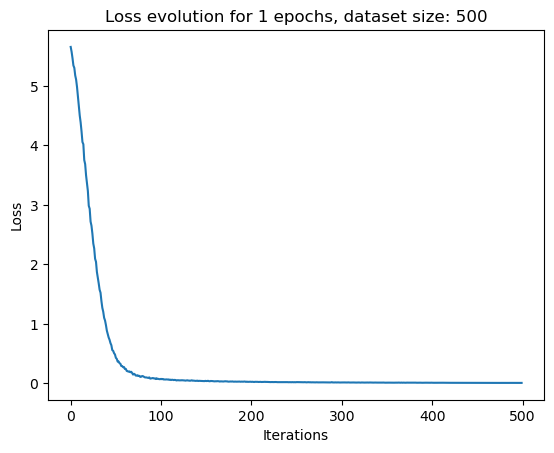

In [33]:
# Ploting loss evolution
plt.plot(loss_eval)
plt.title(f"Loss evolution for {epochs} epochs, dataset size: {len(dataset)}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [34]:
# Generation and evaluation
idx = torch.randint(0, len(dataset) - 1, (1,))
audio_input, video_input, context_input, target = dataset[idx]
generated_sequence = model.generate(
    audio_input, video_input, context_input, start_token_id, end_token_id
)
print(f"Generated sequence: {generated_sequence}")
print(f"Target: {target}")